
#### Running a few different NLP models to understand customer concerns in the ski industry.

#### Questions:


### Imports

In [3]:

import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt


# For using with google collab
# from google.colab import drive
# drive.mount('/content/drive')



### Loading Dataset

In [6]:

# When using File Locally Uncomment
#skiraw = pd.read_csv("file_path")

# When using Google COllab uncomment
# Specify the path to your CSV file
file_path = 'C:/Users/matt/Downloads/OnTheSnow_SkiAreaReviews.csv'

# Read the CSV file
skiraw = pd.read_csv(file_path)
print(skiraw.head())


# Filtering out unwanted columns
skiraw2 = skiraw[['State', 'Ski Area', 'Review Star Rating (out of 5)', 'Review Text']]

# Display the first few rows of the new DataFrame to verify
skiraw2.head()

   Unnamed: 0       State          Ski Area  Reviewer Name  \
0           0  california  squaw-valley-usa  philip sayles   
1           1  california  squaw-valley-usa    mateonelson   
2           2  california  squaw-valley-usa            NaN   
3           3  california  squaw-valley-usa   Ivan Cazares   
4           4  california  squaw-valley-usa        welzbob   

          Review Date  Review Star Rating (out of 5)  \
0  31st December 2019                              3   
1       22nd May 2019                              4   
2      7th March 2019                              2   
3      5th March 2019                              3   
4  26th February 2019                              3   

                                         Review Text  
0  I'm glad our family experienced Squaw but I wo...  
1  I went skiing today 5/22, granite chief was am...  
2  We had a horrible experience on our family ski...  
3  This is the first year I ski Squaw. I've been ...  
4  Both Squaw a

,State,Ski Area,Review Star Rating (out of 5),Review Text
0,california,squaw-valley-usa,3,I'm glad our family experienced Squaw but I wo...
1,california,squaw-valley-usa,4,"I went skiing today 5/22, granite chief was am..."
2,california,squaw-valley-usa,2,We had a horrible experience on our family ski...
3,california,squaw-valley-usa,3,This is the first year I ski Squaw. I've been ...
4,california,squaw-valley-usa,3,"Both Squaw and Alpine have incredible terrain,..."


### Cleaning Data

In [7]:
# Check for null values
null_values = skiraw2.isnull().sum()
print("Null values in each column:\n", null_values)
# Kaggle data so pretty reliable/clean already

# Removing reviews without text because this is NLP based
# Drop rows with null values in 'Review Text'
ski_cleaned = skiraw2.dropna(subset=['Review Text'])

# Checking for Null values again
null_values = ski_cleaned.isnull().sum()
print("Null values in each column:\n", null_values)

ski_cleaned.head()

# Converting review text column to string
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text'].astype(str)

# Verify the conversion
print(ski_cleaned['Review Text Cleaned'].dtype)


Null values in each column:
 State                             0
Ski Area                          0
Review Star Rating (out of 5)     0
Review Text                      12
dtype: int64
Null values in each column:
 State                            0
Ski Area                         0
Review Star Rating (out of 5)    0
Review Text                      0
dtype: int64
object


C:\Users\matt\AppData\Local\Temp\ipykernel_8956\837815565.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text'].astype(str)


## Visualizing Raw Data

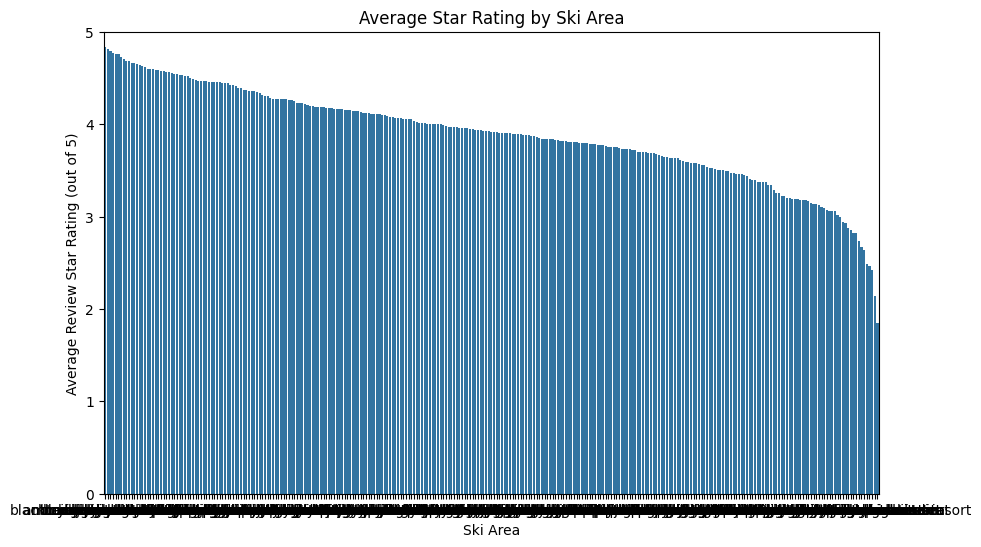

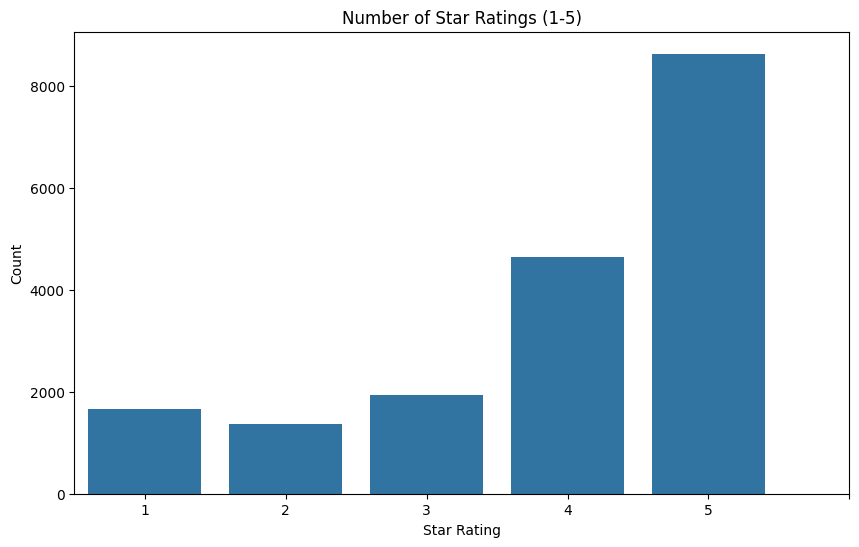

In [8]:
# Bar plot for the average star rating by ski area, sorted by descending order
plt.figure(figsize=(10, 6))
average_ratings = ski_cleaned.groupby('Ski Area')['Review Star Rating (out of 5)'].mean().reset_index()
average_ratings = average_ratings.sort_values(by='Review Star Rating (out of 5)', ascending=False)
sns.barplot(data=average_ratings, x='Ski Area', y='Review Star Rating (out of 5)')
plt.title('Average Star Rating by Ski Area')
plt.xlabel('Ski Area')
plt.ylabel('Average Review Star Rating (out of 5)')
plt.ylim(0, 5)
plt.show()


# Plot the number of star ratings from 1 to 5
plt.figure(figsize=(10, 6))
sns.countplot(data=ski_cleaned, x='Review Star Rating (out of 5)')
plt.title('Number of Star Ratings (1-5)')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5])  # Ensure all ratings from 1 to 5 are shown
plt.show()

### Takeaways
- Every ski resort has an average of above 2 stars
- The distibution of review star ratings leans heavily towards positive ratings

## Extracting Positive and Negative Features Using Sentiment Analysis

### Data cleaning for sentiment Analysis

### Removing Punctuation and Numbers and conveting to lower case


In [8]:
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('[^\w\s]', '')
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('\d+', '')
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.lower()

<ipython-input-8-5bbcae1b24c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('[^\w\s]', '')
<ipython-input-8-5bbcae1b24c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('\d+', '')
<ipython-input-8-5bbcae1b24c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

### Removing Stopwords

In [9]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words('english')

ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

ski_cleaned.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-9-3906536376a4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))


,State,Ski Area,Review Star Rating (out of 5),Review Text,Review Text Cleaned
0,california,squaw-valley-usa,3,I'm glad our family experienced Squaw but I wo...,i'm glad family experienced squaw wont return ...
1,california,squaw-valley-usa,4,"I went skiing today 5/22, granite chief was am...","went skiing today 5/22, granite chief amazing,..."
2,california,squaw-valley-usa,2,We had a horrible experience on our family ski...,horrible experience family ski vacation here. ...
3,california,squaw-valley-usa,3,This is the first year I ski Squaw. I've been ...,first year ski squaw. i've couple sunny powder...
4,california,squaw-valley-usa,3,"Both Squaw and Alpine have incredible terrain,...","squaw alpine incredible terrain, impressive sn..."


### Tokenizing Text

In [10]:
# Tokenizing Text
from nltk.tokenize import word_tokenize

nltk.download('punkt')
ski_cleaned['tokens'] = ski_cleaned['Review Text Cleaned'].apply(word_tokenize)

ski_cleaned.head()




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-10-ccc81adee3ed>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['tokens'] = ski_cleaned['Review Text Cleaned'].apply(word_tokenize)


,State,Ski Area,Review Star Rating (out of 5),Review Text,Review Text Cleaned,tokens
0,california,squaw-valley-usa,3,I'm glad our family experienced Squaw but I wo...,i'm glad family experienced squaw wont return ...,"[i, 'm, glad, family, experienced, squaw, wont..."
1,california,squaw-valley-usa,4,"I went skiing today 5/22, granite chief was am...","went skiing today 5/22, granite chief amazing,...","[went, skiing, today, 5/22, ,, granite, chief,..."
2,california,squaw-valley-usa,2,We had a horrible experience on our family ski...,horrible experience family ski vacation here. ...,"[horrible, experience, family, ski, vacation, ..."
3,california,squaw-valley-usa,3,This is the first year I ski Squaw. I've been ...,first year ski squaw. i've couple sunny powder...,"[first, year, ski, squaw, ., i, 've, couple, s..."
4,california,squaw-valley-usa,3,"Both Squaw and Alpine have incredible terrain,...","squaw alpine incredible terrain, impressive sn...","[squaw, alpine, incredible, terrain, ,, impres..."


# Lemetizing Tokens

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

ski_cleaned['tokens'] = ski_cleaned['tokens'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x])


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
<ipython-input-11-1eb715825881>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['tokens'] = ski_cleaned['tokens'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x])


### Joining Token Back to a string

In [14]:
ski_cleaned['final_text'] = ski_cleaned['tokens'].apply(lambda x: ' '.join(x))

ski_cleaned.head()

<ipython-input-14-ee1171b33370>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['final_text'] = ski_cleaned['tokens'].apply(lambda x: ' '.join(x))


,State,Ski Area,Review Star Rating (out of 5),Review Text,Review Text Cleaned,tokens,final_text
0,california,squaw-valley-usa,3,I'm glad our family experienced Squaw but I wo...,i'm glad family experienced squaw wont return ...,"[i, 'm, glad, family, experienced, squaw, wont...",i 'm glad family experienced squaw wont return...
1,california,squaw-valley-usa,4,"I went skiing today 5/22, granite chief was am...","went skiing today 5/22, granite chief amazing,...","[go, skiing, today, 5/22, ,, granite, chief, a...","go skiing today 5/22 , granite chief amaze , n..."
2,california,squaw-valley-usa,2,We had a horrible experience on our family ski...,horrible experience family ski vacation here. ...,"[horrible, experience, family, ski, vacation, ...",horrible experience family ski vacation here ....
3,california,squaw-valley-usa,3,This is the first year I ski Squaw. I've been ...,first year ski squaw. i've couple sunny powder...,"[first, year, ski, squaw, ., i, 've, couple, s...",first year ski squaw . i 've couple sunny powd...
4,california,squaw-valley-usa,3,"Both Squaw and Alpine have incredible terrain,...","squaw alpine incredible terrain, impressive sn...","[squaw, alpine, incredible, terrain, ,, impres...","squaw alpine incredible terrain , impressive s..."


### Running Seniment On Tokens

In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

ski_cleaned['sentiment_vader'] = ski_cleaned['final_text'].apply(lambda x: sia.polarity_scores(x))
ski_cleaned['compound_vader'] = ski_cleaned['sentiment_vader'].apply(lambda x: x['compound'])
ski_cleaned['sentiment_label_vader'] = ski_cleaned['compound_vader'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))
ski_cleaned.head()

# Comparing Vader Lesxicon to Transformers sentiment

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-22-67137925a25c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['sentiment_vader'] = ski_cleaned['final_text'].apply(lambda x: sia.polarity_scores(x))
<ipython-input-22-67137925a25c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['compound_vader'] = ski_cleaned['sentiment_vader'].apply(lambda x: x['compound'])
<ipython-input-22-67137925a25c

,State,Ski Area,Review Star Rating (out of 5),Review Text,Review Text Cleaned,tokens,final_text,sentiment_vader,compound_vader,sentiment_label_vader
0,california,squaw-valley-usa,3,I'm glad our family experienced Squaw but I wo...,i'm glad family experienced squaw wont return ...,"[i, 'm, glad, family, experienced, squaw, wont...",i 'm glad family experienced squaw wont return...,"{'neg': 0.2, 'neu': 0.632, 'pos': 0.169, 'comp...",-0.6697,negative
1,california,squaw-valley-usa,4,"I went skiing today 5/22, granite chief was am...","went skiing today 5/22, granite chief amazing,...","[go, skiing, today, 5/22, ,, granite, chief, a...","go skiing today 5/22 , granite chief amaze , n...","{'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'comp...",0.8658,positive
2,california,squaw-valley-usa,2,We had a horrible experience on our family ski...,horrible experience family ski vacation here. ...,"[horrible, experience, family, ski, vacation, ...",horrible experience family ski vacation here ....,"{'neg': 0.137, 'neu': 0.863, 'pos': 0.0, 'comp...",-0.5423,negative
3,california,squaw-valley-usa,3,This is the first year I ski Squaw. I've been ...,first year ski squaw. i've couple sunny powder...,"[first, year, ski, squaw, ., i, 've, couple, s...",first year ski squaw . i 've couple sunny powd...,"{'neg': 0.076, 'neu': 0.596, 'pos': 0.327, 'co...",0.9973,positive
4,california,squaw-valley-usa,3,"Both Squaw and Alpine have incredible terrain,...","squaw alpine incredible terrain, impressive sn...","[squaw, alpine, incredible, terrain, ,, impres...","squaw alpine incredible terrain , impressive s...","{'neg': 0.099, 'neu': 0.739, 'pos': 0.162, 'co...",0.6597,positive


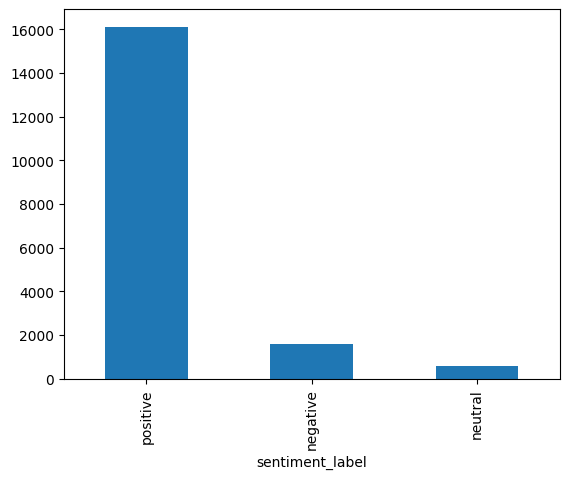

In [ ]:
ski_cleaned['sentiment_label_vader'].value_counts().plot(kind='bar')
plt.show()

### Comments on sentiment label
#### Sentiment score is overwhelmingly positive compared to star rating, may be worth including neutural data in analysis to have more information

In [ ]:
ski_cleaned.head()

,State,Ski Area,Review Star Rating (out of 5),Review Text,Review Text Cleaned,tokens,final_text,sentiment,compound,sentiment_label
0,california,squaw-valley-usa,3,I'm glad our family experienced Squaw but I wo...,i'm glad family experienced squaw wont return ...,"[i, 'm, glad, family, experienced, squaw, wont...",i 'm glad family experienced squaw wont return...,"{'neg': 0.2, 'neu': 0.632, 'pos': 0.169, 'comp...",-0.6697,negative
1,california,squaw-valley-usa,4,"I went skiing today 5/22, granite chief was am...","went skiing today 5/22, granite chief amazing,...","[go, skiing, today, 5/22, ,, granite, chief, a...","go skiing today 5/22 , granite chief amaze , n...","{'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'comp...",0.8658,positive
2,california,squaw-valley-usa,2,We had a horrible experience on our family ski...,horrible experience family ski vacation here. ...,"[horrible, experience, family, ski, vacation, ...",horrible experience family ski vacation here ....,"{'neg': 0.137, 'neu': 0.863, 'pos': 0.0, 'comp...",-0.5423,negative
3,california,squaw-valley-usa,3,This is the first year I ski Squaw. I've been ...,first year ski squaw. i've couple sunny powder...,"[first, year, ski, squaw, ., i, 've, couple, s...",first year ski squaw . i 've couple sunny powd...,"{'neg': 0.076, 'neu': 0.596, 'pos': 0.327, 'co...",0.9973,positive
4,california,squaw-valley-usa,3,"Both Squaw and Alpine have incredible terrain,...","squaw alpine incredible terrain, impressive sn...","[squaw, alpine, incredible, terrain, ,, impres...","squaw alpine incredible terrain , impressive s...","{'neg': 0.099, 'neu': 0.739, 'pos': 0.162, 'co...",0.6597,positive


### Sorting Reviews out based on sentiment label for topic modeling